# Дипломное задание
Данные - реальная компания, продающая оборудование. Они подкорректированные , т.к. под NDA  
Берем оттуда месяц и год продаж, клиенты, сумма продаж.  
Необходимо проанализировать продажи и дать рекомендации бизнесу  
По итогу   
дадим рекомендацию по кол-во сейлс менеджеров в отделе продаж  
предскажим оборот на ближайщее время  
построим модели , предсказывающие продажи 

In [122]:
import numpy as np
import pandas as pd # Для работы с данными
from chart_studio import plotly
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from itertools import product

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from math import sqrt

import statsmodels.api as smapi

import scipy.stats as scs
from cycler import cycler


In [2]:
df = pd.read_csv('Data_file.csv')

In [3]:
for i in range(df.shape[0]):
    df['Клиент'][i] = 'Клиент' + str(i) #убираем реальные названия клиентов для отображения
df.head()

,Unnamed: 0,Клиент,01CY2019,02CY2019,03CY2019,04CY2019,05CY2019,06CY2019,07CY2019,08CY2019,...,11CY2021,12CY2021,01CY2022,02CY2022,03CY2022,04CY2022,05CY2022,06CY2022,07CY2022,08CY2022
0,0,Клиент0,4785.2,324.8,697.0,2250.0,18008.4,312.4,1517.8,3446.6,...,13940.4,30524.4,14192.2,18034.4,35431.0,33341.4,3313.4,7553.4,0.2,0.0
1,1,Клиент1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1674.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Клиент2,0.0,0.0,2804.8,1196.0,12240.0,0.0,0.0,0.0,...,0.0,290.4,0.0,4640.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Клиент3,0.0,0.0,0.0,17570.0,0.0,2620.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Клиент4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9208.0,8897.6,0.0,0.0,0.0,0.0,0.0,1898.0,0.0,0.0


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# название столбцов - месяц и год
df_columns = df.columns

In [6]:
df_original = df.copy() #на всякий случай будем держать оригинал датафрейма в df_original

# посчитаем оборот компании

In [7]:
#считаем оборот компании
Sum_turnover_list = []

for i in df_columns[1:]:
    Sum_turnover_list.append( df[i][ df[i] > 0 ].sum())

# print(Sum_turnover_list)

df_turnover_months = pd.Series(Sum_turnover_list)
df_turnover_months.index = df_columns[1:]


In [8]:
df_turnover_months = pd.DataFrame({'Month':df_turnover_months.index, 'Turnover':df_turnover_months.values})

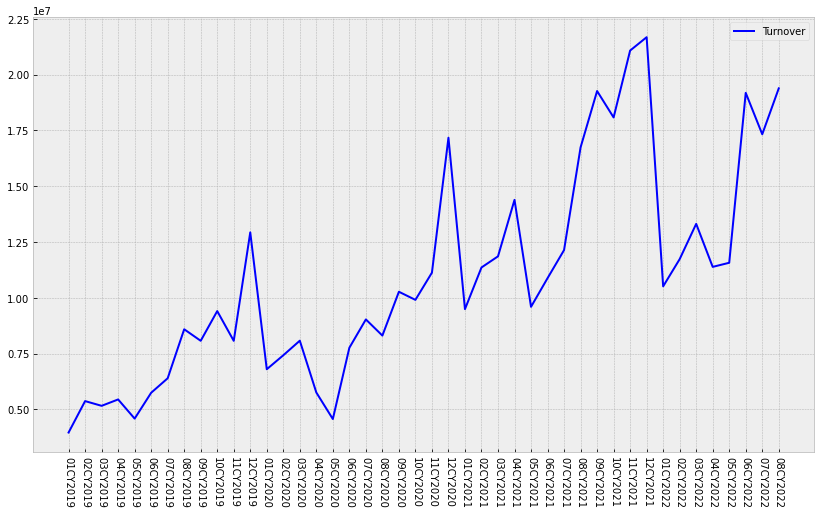

In [313]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = df_turnover_months['Month']#plt.axes()
#     best_mdl.plot_predict(1, len(series)+100, ax=ax)
    plt.plot(df_turnover_months['Month'],
             df_turnover_months['Turnover'] , color='blue', label='Turnover') 
    plt.xticks (Rotation = -90)
    plt.legend()
    plt.show()

# строим график оборота компании, тренда и сезональности, используя statsmodels.tsa.seasonal seasonal_decompose

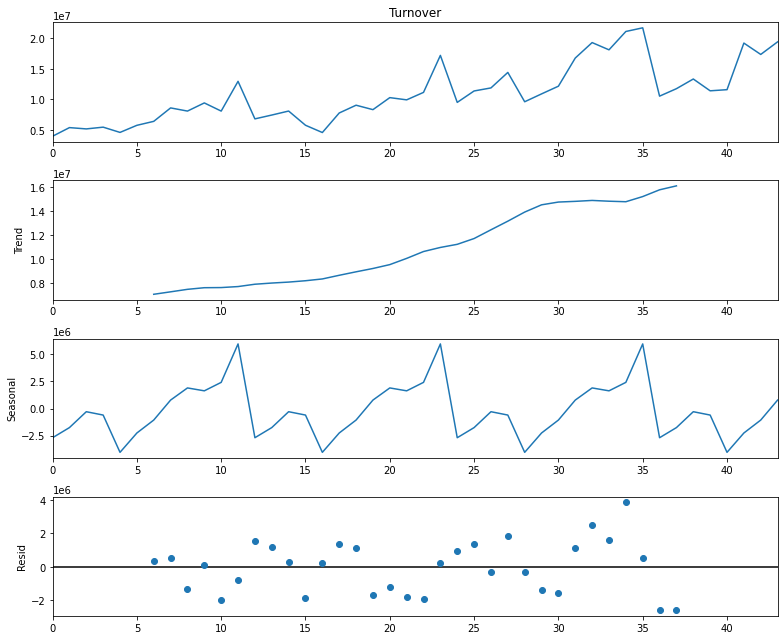

In [36]:
# импортируем функцию seasonal_decompose из statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
 
# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
 
# применяем функцию к данным о перевозках data_11['Turnover_season']
decompose = seasonal_decompose(df_turnover_months['Turnover'], period = 12)
# decompose = seasonal_decompose(data_11['Turnover_season'][12:], period = 12)
decompose.plot()
 
plt.show()

# строим график процентного отношения оборота текущего месяца к предыдущему

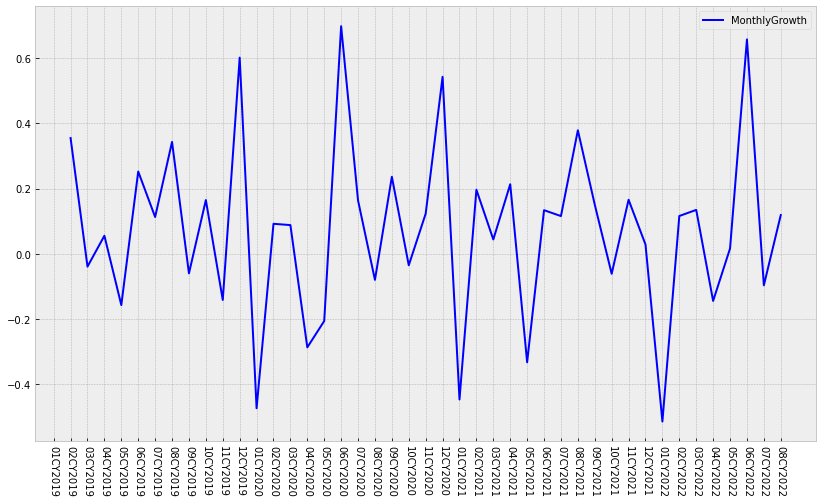

In [15]:
#using pct_change() function to see monthly percentage change
df_turnover_months['MonthlyGrowth'] = df_turnover_months['Turnover'].pct_change()

with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = df_turnover_months['Month']#plt.axes()
#     best_mdl.plot_predict(1, len(series)+100, ax=ax)
    plt.plot(df_turnover_months['Month'],
             df_turnover_months['MonthlyGrowth'] , color='blue', label='MonthlyGrowth') 
    plt.xticks (Rotation = -90)
    plt.legend()
    plt.show()

очевидно, что пик продаж в декабре и самые маленькие продажи в мае

# исследуем временной ряд продаж


In [16]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [17]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [18]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [19]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

# SARIMA. Оборот всей компании
ищем лучшую модель SARIMA в зависимости о параметра order  
order tuple, optional  
The (p,d,q) order of the model for the autoregressive, differences, and moving average components
Элементы тренда  
Есть три элемента тренда, которые требуют настройки.  

Они такие же, как модель ARIMA; в частности:  

п: Порядок авторегрессии тренда.  
d: Порядок изменения тренда.  
Q: Тренд скользящей средней.    

Сезонные элементы  
Есть четыре сезонных элемента, которые не являются частью ARIMA, которые должны быть настроены; они есть:  

п: Сезонный порядок авторегрессии.  
D: Порядок сезонных разниц.  
Q: Сезонный порядок скользящих средних.  
м: Количество временных шагов за один сезонный период.  

In [340]:
%%time
warnings.filterwarnings('ignore')
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df_turnover_months['Turnover'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]

      parameters          aic
26  (1, 1, 1, 0)  1010.465873
1   (0, 0, 1, 0)  1010.891428
11  (0, 2, 1, 0)  1011.182192
46  (2, 1, 1, 0)  1011.470615
25  (1, 1, 0, 0)  1011.671983
Wall time: 2min 23s


In [341]:
%%time
warnings.filterwarnings('ignore')
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)
results = []
best_aic = float("inf")

month_test = 6
df_turnover_months_train = df_turnover_months['Turnover'][:-month_test]
df_turnover_months_test = df_turnover_months['Turnover'][-month_test:]

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df_turnover_months_train, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model_6 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]

      parameters         aic
25  (1, 1, 0, 0)  810.996436
20  (1, 0, 0, 0)  811.613942
5   (0, 1, 0, 0)  811.710803
1   (0, 0, 1, 0)  811.924989
0   (0, 0, 0, 0)  812.210967
Wall time: 1min 53s


In [346]:
forecasted = list(best_model.predict(1,len(df_turnover_months['Turnover']) ))
actual = list((df_turnover_months['Turnover']))

mape = 0
for i in range(len(df_turnover_months['Turnover'])):
    mape = mape + np.abs( ( actual[i] - forecasted[i] ) / actual[i])
#     print(np.abs( ( actual[i] - forecasted[i] ) / actual[i]))
print('SARIMA без train test')
print('MAPE = ', round(mape / len(actual) * 100, 1), '%')

SARIMA без train test
MAPE =  15.4 %


In [354]:
forecasted = list(best_model_6.predict(len(df_turnover_months['Turnover'])-6,len(df_turnover_months['Turnover']) ))
actual = list(df_turnover_months_test)

# forecasted = list(best_model_6.predict(1,len(df_turnover_months['Turnover']) ))
# actual = list((df_turnover_months['Turnover']))

mape = 0
for i in range(len(actual)):
    mape = mape + np.abs( ( actual[i] - forecasted[i] ) / actual[i])
#     print(np.abs( ( actual[i] - forecasted[i] ) / actual[i]))
print('SARIMA c train test. MAPE на тестовой выборке')
print('MAPE = ', round(mape / len(actual) * 100, 1), '%')

SARIMA c train test. MAPE на тестовой выборке
MAPE =  15.8 %


C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-351-62fc7ee7852f>:15: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



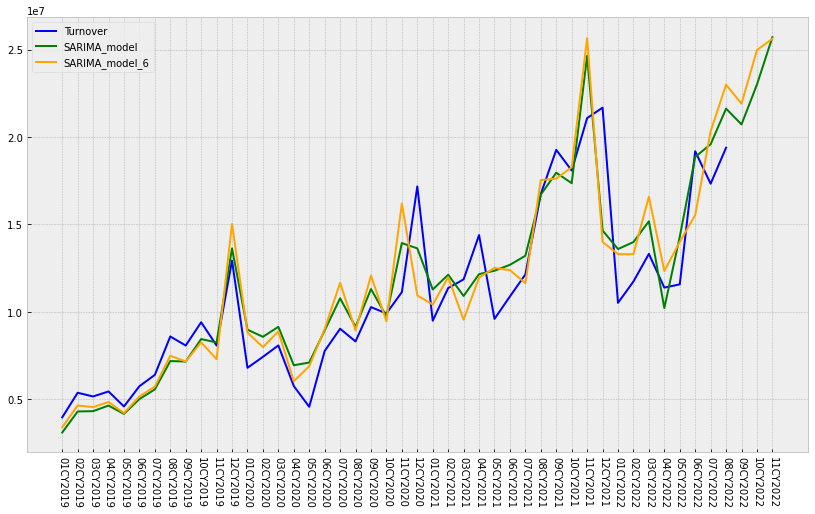

In [351]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = df_turnover_months['Month']#plt.axes()
#     best_mdl.plot_predict(1, len(series)+100, ax=ax)
    plt.plot(df_turnover_months['Month'],
             df_turnover_months['Turnover'] , color='blue', label='Turnover') #(1, len(series)+100, ax=ax)
#     plt.plot(df_turnover_months['Turnover'].rolling(window = 3).mean(), label = 'Скользящее среднее за 3 месяцев', color = 'orange')
#     plt.plot(double_exponential_smoothing(df_turnover_months['Turnover'], 0.9, 0.02), 
#              label="Alpha {}, beta {}".format(0.7, 0.02) , color = 'red')
    plt.plot(list(df_turnover_months['Month']) + ['09CY2022']+ ['10CY2022']+ ['11CY2022'],
             best_model.predict(1,len(df_turnover_months['Turnover']) + 3), label = 'SARIMA_model', color = 'green')
    plt.plot(list(df_turnover_months['Month']) + ['09CY2022']+ ['10CY2022']+ ['11CY2022'],
             best_model_6.predict(1,len(df_turnover_months['Turnover']) + 3), label = 'SARIMA_model_6', color = 'orange')
    plt.legend()
    plt.xticks (Rotation = -90)
    plt.show()

вычислим среднюю абсолютную ошибку (MAPE) модели SARIMA

In [330]:
forecasted = list(best_model.predict(1,len(df_turnover_months['Turnover']) ))
actual = list(df_turnover_months['Turnover'])

mape = 0
for i in range(len(actual)):
    mape = mape + np.abs( ( actual[i] - forecasted[i] ) / actual[i])
#     print(np.abs( ( actual[i] - forecasted[i] ) / actual[i]))
print('MAPE = ', round(mape / len(actual) * 100, 1), '%')

MAPE =  15.4 %


C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [71]:
# import scipy.stats as scs
# series_box, lambda_1 = scs.boxcox(list(df_turnover_months['Turnover'])) # прибавляем единицу, так как в исходном ряде есть нули
# tsplot(series_box, lags=15)

In [31]:
from statsmodels.graphics.tsaplots import plot_predict

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

In [20]:

y = np.array(series) #оборот в месяц
X = range(len(y)) # месяц
X = np.array(X)
X = X.reshape(-1, 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3,  random_state = 42)

отрисуем интервалы и предсказания будущих периодов (3 месяца). Модель best_mdl


C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-357-0ac0bbcd354d>:16: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



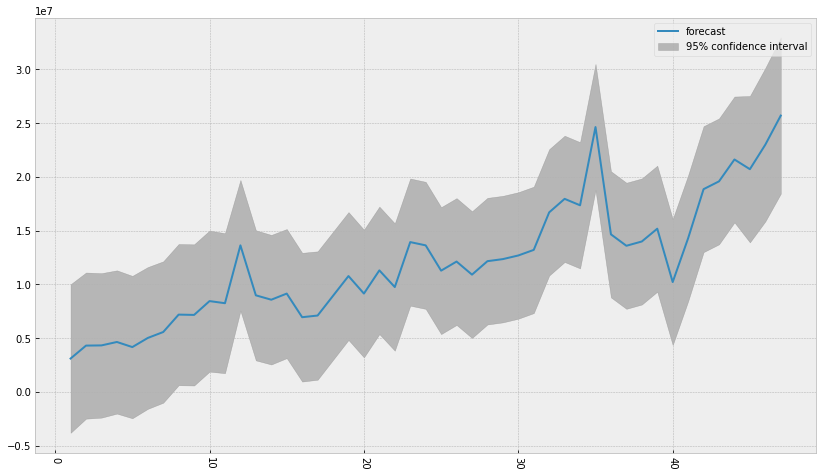

44    2.162405e+07
45    2.072039e+07
46    2.300370e+07
47    2.571050e+07
Name: predicted_mean, dtype: float64


In [357]:
from statsmodels.graphics.tsaplots import plot_predict
# df_month_name = list(df_turnover_months['Month'])
# df_month_name.append( '09CY2022')#, '10CY2022','11CY2022')
# df_month_name.append( '10CY2022')
# df_month_name.append( '11CY2022')
series = list(df_turnover_months['Turnover'])
best_mdl = best_model

with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
#     best_mdl.plot_predict(1, len(series)+100, ax=ax)
    plot_predict( best_mdl, 1, len(series)+3, ax=ax, label='predict')
#     plt.plot(df_turnover_months['Month'], series, color='red', label='Real_Data')
#     plt.plot(series, color='blue', label='best_mdl')
    plt.xticks (Rotation = -90)
    plt.legend()
    plt.show()
    
print(best_mdl.predict(len(series), len(series)+3))

# проанализируем количество клиентов каждый месяц, оборот которых больше clients_turnover_int каких-то едениц
# берем 2 тыс , т.к. это основные клиенты приносящие доход (оборот)

<ipython-input-37-c04fe41b98ad>:22: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



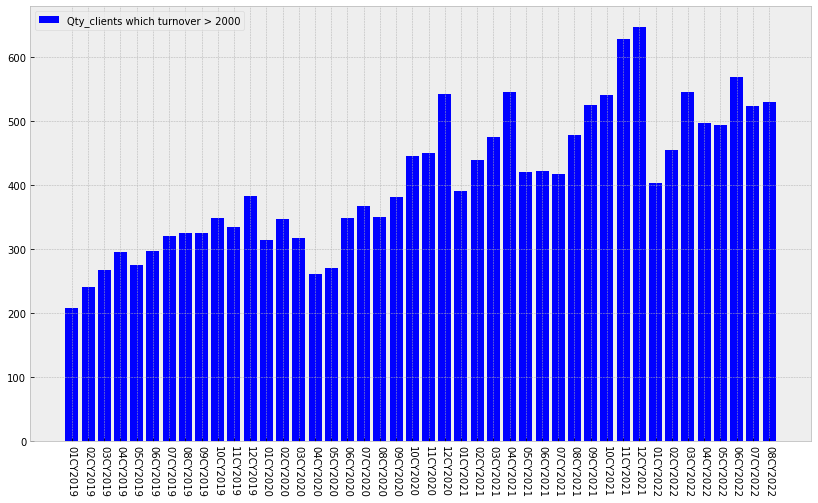

<ipython-input-37-c04fe41b98ad>:22: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



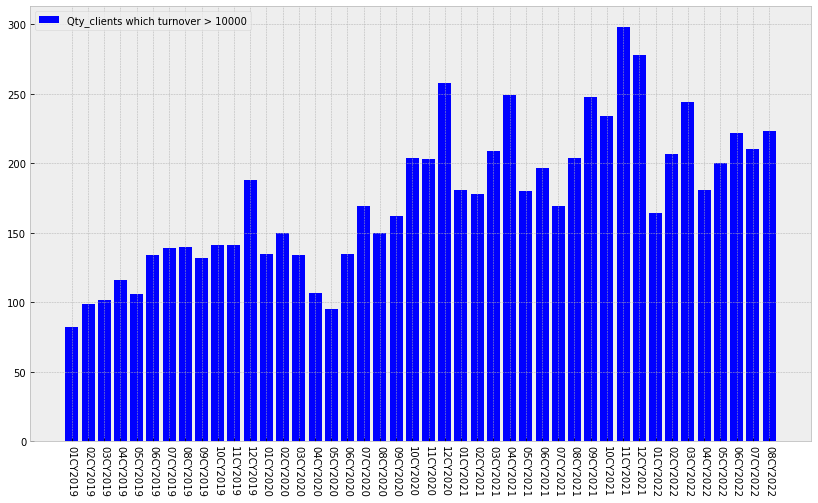

<ipython-input-37-c04fe41b98ad>:22: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



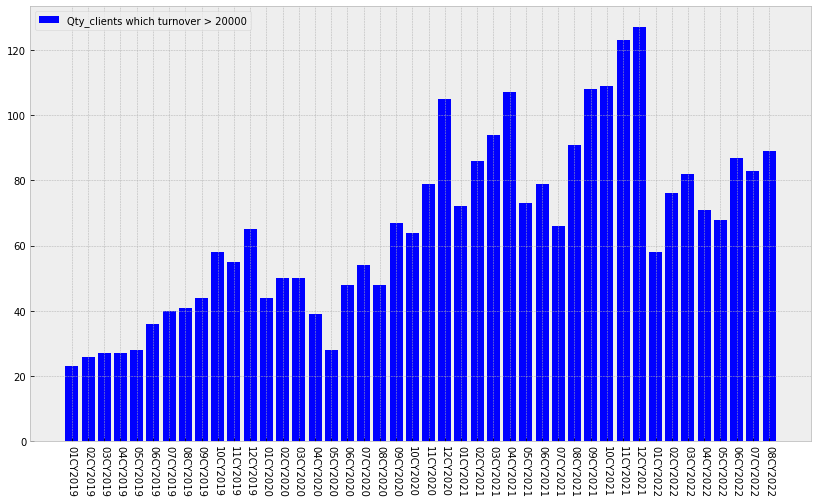

<ipython-input-37-c04fe41b98ad>:22: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



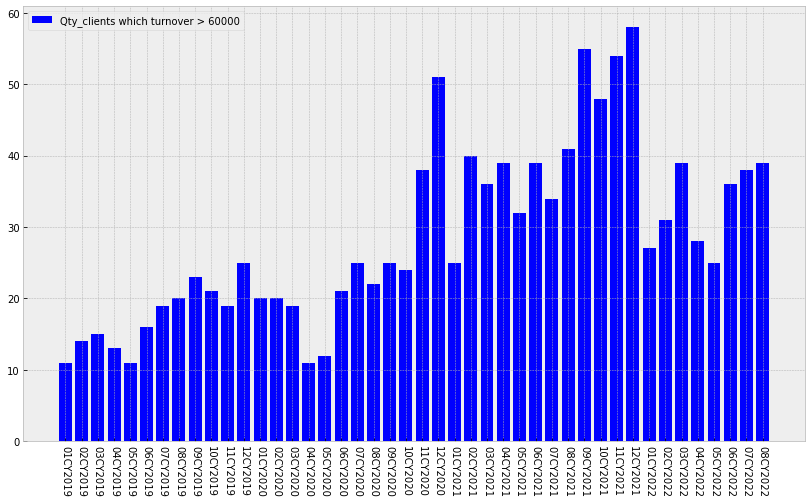

In [37]:
#количество клиентов каждый месяц

clients_turnover_list = [2000,10000,20000,60000]
# clients_turnover_int = 10000

for clients_turnover_int in clients_turnover_list:
    Qty_clients_list = []
    for i in df_columns[1:]:
        Qty_clients_list.append( df[i][ df[i] > clients_turnover_int].count() )

    # print(Qty_clients_list)

    df_Qty_clients_list = pd.Series(Qty_clients_list)
    df_Qty_clients_list.index = df_columns[1:]

    df_Qty_clients_list = pd.DataFrame({'Month':df_Qty_clients_list.index, 'Qty_clients':df_Qty_clients_list.values})
    with plt.style.context('bmh'):
        plt.figure(figsize=(14,8))
#         ax = df_Qty_clients_list['Month']#plt.axes()
        plt.bar(df_Qty_clients_list['Month'], df_Qty_clients_list['Qty_clients'] , color='blue', 
                label = 'Qty_clients which turnover > ' + str(clients_turnover_int)) 
        plt.xticks (Rotation = -90)
        plt.legend()
        plt.show()

#     plot_data = [
#         go.Bar(
#             x=df_Qty_clients_list['Month'],
#             y=df_Qty_clients_list['Qty_clients'],
#         )
#     ]

#     plot_layout = go.Layout(
#             xaxis={"type": "category"},
#             title='Qty_clients which turnover > ' + str(clients_turnover_int)
#         )

#     fig = go.Figure(data=plot_data, layout=plot_layout)
#     pyoff.iplot(fig)


здесь также видно, что кол-во клиентов максимально в декабре и минимально мае. 

Разделим всех клиентов на два типа : старые (Old_Client), которые покупают как минимум (qty_months_dont_buy+1) месяцев подряд
и не работающих (оборот менее sum_minimum_month)(Client_dont_work). Посмотрим как во времени эти параметры менялись

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-38-99b691aade0b>:52: UserWarning:

'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>

<ipython-input-38-99b691aade0b>:53: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



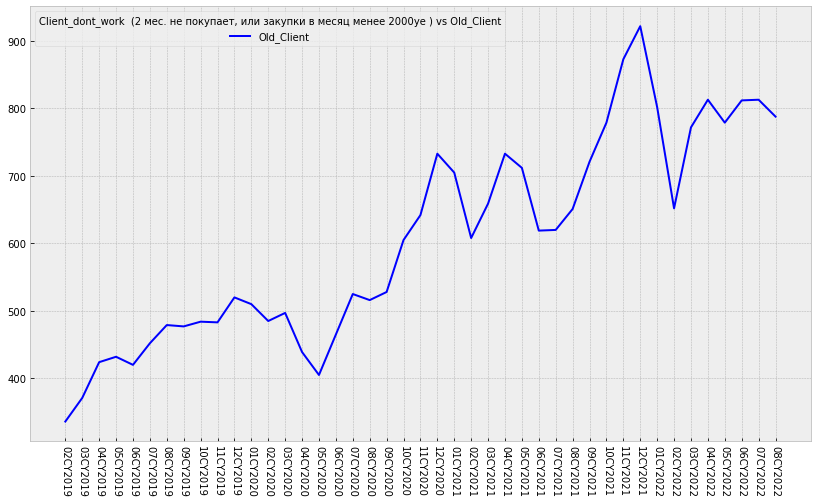

<ipython-input-38-99b691aade0b>:52: UserWarning:

'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>

<ipython-input-38-99b691aade0b>:53: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



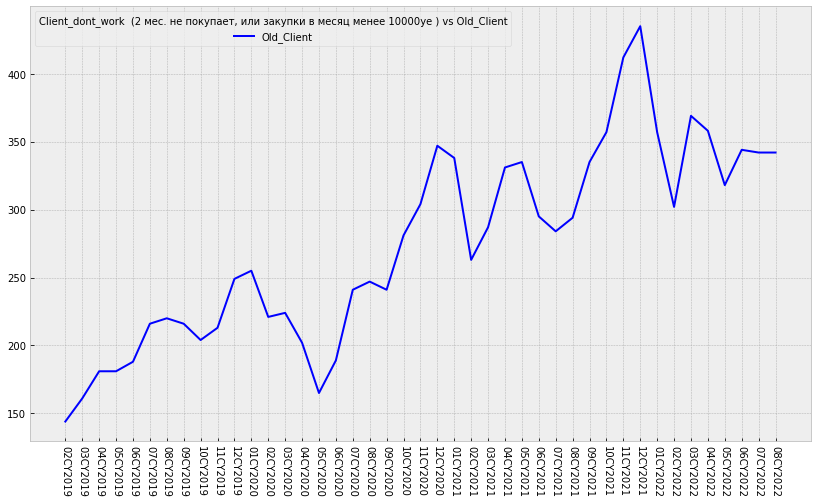

<ipython-input-38-99b691aade0b>:52: UserWarning:

'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>

<ipython-input-38-99b691aade0b>:53: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



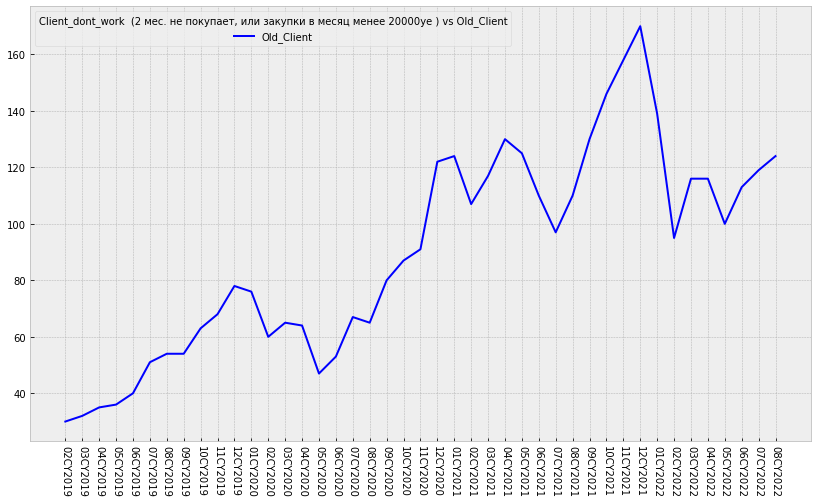

<ipython-input-38-99b691aade0b>:52: UserWarning:

'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>

<ipython-input-38-99b691aade0b>:53: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



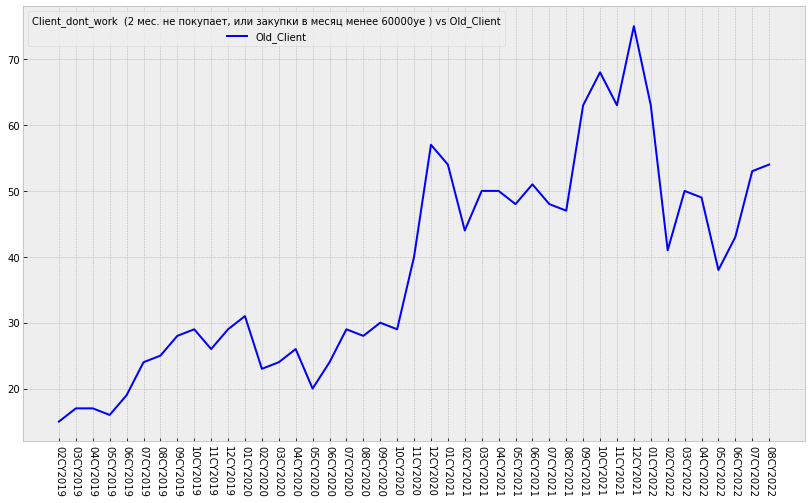

In [38]:
#строим график активных и неактивных клиентов по месяцам
df_new_client = pd.DataFrame({'Month':df_columns[1:]})
qty_months_dont_buy = 1
sum_minimum_month_list = [2000,10000,20000,60000]

for sum_minimum_month in sum_minimum_month_list:

    for index, row in df.iterrows():
        new_client = 0
        list_new_client = []
        for i in df_columns[1:]: 
            if row[i] > sum_minimum_month : 
                new_client = 0 #если есть оборот, то признак нового клиента обнуляем
            else : 
                new_client = new_client + 1
            if new_client > qty_months_dont_buy: #если клиент не берет более qty_months_dont_buy месяцев подряд, то это потенциально новый клиент. Или ушедший
                list_new_client.append('Client_dont_work')
            else :
                list_new_client.append('Old_Client')

        df_new_client[row['Клиент']] = list_new_client

    #транспонируем dataframe для удобства подсчета кол-в разных типов клиентов
    df_new_client_t = df_new_client.T.copy()
    df_new_client_t.columns = df_columns[1:]
    df_new_client_t = df_new_client_t.reset_index(drop=True)
    df_new_client_t.drop([0, 0], inplace = True)
    df_new_client_t.head()

    #считаем кол-ва активных и неактивных клиентов каждый месяц
    df_new_client_status = pd.DataFrame()
    df_new_client_status['Status'] = ['Client_dont_work', 'Old_Client']

    for i in df_columns[1:]:
        list_status_client = []
        list_status_client.append(df_new_client_t[df_new_client_t[i] == 'Client_dont_work'].count()[0])
        list_status_client.append(df_new_client_t[df_new_client_t[i] == 'Old_Client'].count()[0])
        df_new_client_status[i] = list_status_client

        
    with plt.style.context('bmh'):
        plt.figure(figsize=(14,8))
#         ax = df_Qty_clients_list['Month']#plt.axes()
        plt.plot(df_new_client_status.columns[2:], 
                 df_new_client_status[df_new_client_status['Status'] == 'Old_Client'].values.tolist()[0][2:] , color='blue', 
                label = 'Old_Client') 
#         plt.plot(df_new_client_status.columns[1:], 
#                  df_new_client_status[df_new_client_status['Status'] == 'Client_dont_work'].values.tolist()[0][1:] , color='red', 
#                 label = 'Client_dont_work') 
        plt.legend(title='Client_dont_work  (' + str(qty_months_dont_buy+1) + 
                     ' мес. не покупает, или закупки в месяц менее '+str(sum_minimum_month) + 'уе ) vs Old_Client')
        plt.locator_params(axis='x', nbins=10)
        plt.xticks (Rotation = -90)
        plt.show()        
        

#     plot_data = [
#         go.Scatter(
#             x=df_new_client_status.columns[1:],
#             y=df_new_client_status[df_new_client_status['Status'] == 'Old_Client'].values.tolist()[0][1:],
#             name = 'Old_Client'
#         ),
#         go.Scatter(
#             x=df_new_client_status.columns[1:],
#             y=df_new_client_status[df_new_client_status['Status'] == 'Client_dont_work'].values.tolist()[0][1:],
#             name = 'Client_dont_work'
#         )
#     ]

#     plot_layout = go.Layout(
#             xaxis={"type": "category"},
#             title='Client_dont_work vs Existing (' + str(qty_months_dont_buy+1) + 
#                     ' мес. не покупает, или закупки в месяц менее '+str(sum_minimum_month) + 'уе )'
#         )
#     fig = go.Figure(data=plot_data, layout=plot_layout)
#     pyoff.iplot(fig)

клиентская база средних клиентов (закупки хотя бы раз в два месяца и более 2 тыс н.у.) растет.
За два последних года с ~500 до 750. В пике было около 1000. В декабре этого года можно предполагать будет в районе 1200  

Крупных клиентов (оборот более 60 тыс у.е. в месяц) порядка 50.   
Обычно на такие обороты 5 клиентов на сейлс менеджера. Кол-во сейлс менеджеров, отвечающих за крупнх клиентов 10.

Средних клиентов (оборот от 20 до 60 тыс у.е.) 120-50 = 70 клиентов.
Здесь примерно 10 клиентов на одного сейлс менеджера. Итого на этот тип клиентов 7 сейлс менеджеров.

Клиентов с оборотом 10-20 тыс у.е. 350-120 = 230. 
Здесь примерно 20 клиентов на одного сейлс менеджера. Итого на этот тип клиентов 12 сейлс менеджеров.

Клиентов с оборотом 2-10 тыс у.е. 800-350 = 550. 
Здесь примерно 50 клиентов на одного сейлс менеджера. Итого на этот тип клиентов 11 сейлс менеджеров.

Клентов с оборотом менее 2 тыс у.е. обслуживает B2B.

Итого отдел продаж ориентировочно должен быть 40 человек на такие обороты
плюс
команда, поддерживающая B2B


In [39]:
from sklearn.linear_model import LogisticRegression

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [40]:
from sklearn.pipeline import make_pipeline # используем пайплайны для удобства
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

# model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [41]:
from sklearn.svm import SVC

# Список крупных клиентов
подготовка данных для моделирования клиента с оборотом более 1000 кратного от минимального порога клиента в sum_minimum_month_list и которые делают не менее 50 кратного оборота sum_minimum_month_list каждый месяц (то есть нет провалов в продажах)

In [358]:
#оставим лишь период 12 месяцев : с июля
print(df_columns[33:44])

# df_original = df.copy()
df = df_original.copy()
df_columns = df.columns

# for i_column in df_columns[1:32]:
#     df.drop(i_column, axis=1, inplace=True)
# df_columns = df.columns
df.head()

delete_clients = 0
delete_clients_index = []
for index, row in df.iterrows(): 
#         print(index)
#         print(sum(list(row)[1:]))
        if sum(list(row)[1:]) < 1000*sum_minimum_month_list[0] or len(list(filter(lambda x: x <= 50*sum_minimum_month_list[0], list(row)[1:]))) > 3:
            delete_clients = delete_clients + 1
            delete_clients_index.append(index)
#         break
print(delete_clients)

delete_clients_index[:20]

df = df.drop(delete_clients_index, axis=0)

df.shape

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Index(['09CY2021', '10CY2021', '11CY2021', '12CY2021', '01CY2022', '02CY2022',
       '03CY2022', '04CY2022', '05CY2022', '06CY2022', '07CY2022'],
      dtype='object')
4053


(2, 45)

крупных клиентов, удовлетворяющих условиям выше равно 11

In [359]:
df.head()

,Клиент,01CY2019,02CY2019,03CY2019,04CY2019,05CY2019,06CY2019,07CY2019,08CY2019,09CY2019,...,11CY2021,12CY2021,01CY2022,02CY2022,03CY2022,04CY2022,05CY2022,06CY2022,07CY2022,08CY2022
1033,Клиент1033,841949.8,1005872.8,753967.6,742569.2,669018.8,607661.6,868750.4,1135704.8,1224795.0,...,2334149.6,1228845.0,903092.8,904670.6,255768.0,773544.0,603977.6,1469076.8,1121297.8,2456967.2
3020,Клиент3020,171445.8,190003.2,147060.8,183224.6,125669.6,135650.8,245581.2,212841.6,239598.4,...,261444.4,386598.8,200459.6,195529.4,137290.8,185784.6,205790.8,265586.8,279286.0,190982.0


In [58]:
for index, row in df.iterrows():
    print(list(row)[1:])
    break

[841949.8, 1005872.8, 753967.6, 742569.2, 669018.8, 607661.6, 868750.4, 1135704.8, 1224795.0, 1497694.4, 1290329.0, 1134548.6, 863454.0, 803417.2, 1244378.0, 90920.8, 500633.0, 1158870.4, 874902.6, 741514.0, 845009.2, 850922.8, 740365.6, 1362057.2, 584382.8, 559301.0, 618717.6, 1229734.0, 484740.8, 859929.2, 1872280.2, 1591259.0, 1083209.2, 1731999.6, 2334149.6, 1228845.0, 903092.8, 904670.6, 255768.0, 773544.0, 603977.6, 1469076.8, 1121297.8, 2456967.2]


C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# получился список крупных клиента. Для каждого из них построим свою модель Arima. Получим словарь {Клиент:Модель}

In [369]:
# from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings('ignore')
num_of_itter = 0
num_of_clients =2 #кол-во киентов, которых хотим увидеть на графике. 
dic_client_Arima = {}
# list_sept_nov = ['09CY22','10CY22','11CY22']
for index, row in df.iterrows():
#     print(list(row)[1:])
    period_length = list(row)
    train = row[1:]
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    ps = range(0, 4)#ps = range(0, 5)
    d=1
    qs = range(0, 4)#qs = range(0, 4)
    Ps = range(0, 4)#Ps = range(0, 5)
    D=1
    Qs = range(0, 1)#Qs = range(0, 1)

    parameters = product(ps, qs, Ps, Qs)
    parameters_list = list(parameters)
    len(parameters_list)
    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(list(row[1:]), order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
            aic = model.aic
            #сохраняем лучшую модель, aic, параметры
            if aic < best_aic:
                best_mdl = model
                best_aic = aic
                best_param = param

            dic_client_Arima[list(row)[0]]  = best_mdl
   #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
    num_of_itter = num_of_itter + 1
    if num_of_itter >= num_of_clients :  
#         continue 
        break



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:35<00:00,  1.83it/s]


In [372]:
dic_client_Arima

{'Клиент1033': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x26d91160eb0>,
 'Клиент3020': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x26d90df46a0>}

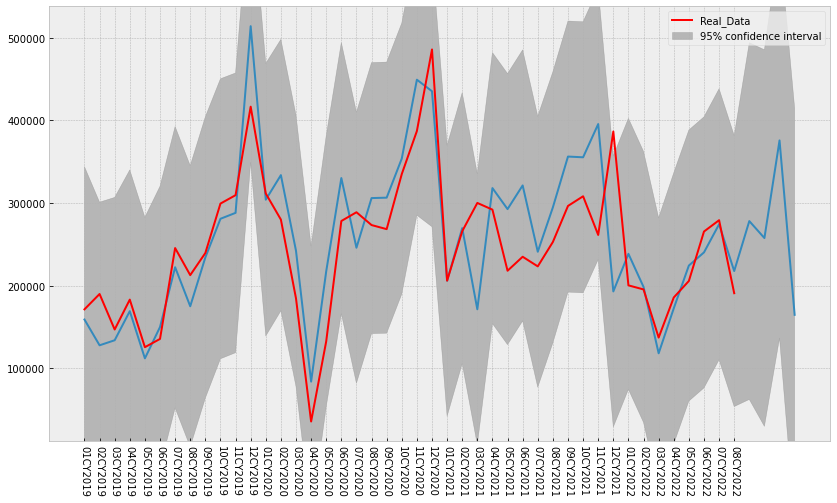

In [373]:
best_mdl = dic_client_Arima['Клиент3020']
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict( best_mdl, 1, len(period_length) + 3, ax=ax, label='predict')
    plt.plot(df_turnover_months['Month'], list(row)[1:], color='red', label='Real_Data')
    plt.xticks (Rotation = -90)
    plt.legend()
    plt.show()

In [374]:
forecasted = list(best_mdl.predict(1,len(df_turnover_months['Turnover']) ))
actual = list(row[1:])

mape = 0
for i in range(len(actual)):
    mape = mape + np.abs( ( actual[i] - forecasted[i] ) / actual[i])
#     print(np.abs( ( actual[i] - forecasted[i] ) / actual[i]))
print('MAPE = ', round(mape / len(actual) * 100, 1), '%')

MAPE =  19.3 %


In [68]:
#предсказание оборота Клиента161 на 3 месяца вперед
# dic_client_Arima['Клиент161'].predict(len(list(row)[1:]),len(list(row)[1:])+3)

# SSA
сингулярный анализ. попробуем разложить продажи на составляющие

In [71]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

выберем крупных клиентов, у которых суммарный оборот за весь период более 1000*sum_minimum_month_list[0] и кол-во месяцев,  
где оборот был менее 20*sum_minimum_month_list[0] не более трех.  
Таких клиентов 8

In [73]:
df = df_original.copy()
df_columns = df.columns

delete_clients = 0
delete_clients_index = []
for index, row in df.iterrows(): 
        if sum(list(row)[1:]) < 1000*sum_minimum_month_list[0] or len(list(filter(lambda x: x <= 20*sum_minimum_month_list[0], list(row)[1:]))) > 3:
            delete_clients = delete_clients + 1
            delete_clients_index.append(index)
print(delete_clients)

delete_clients_index[:20]

df = df.drop(delete_clients_index, axis=0)

df.shape

4047


(8, 45)

In [74]:
Clients_turnover_list = []
for index, row in df.iterrows():
#     print(list(row))
    Clients_turnover_list.append(list(row)[1:])
    

Разложим продажи клиента, идущего первым в списке на 8 составляющих

In [382]:
# list(df_turnover_months['Turnover'])

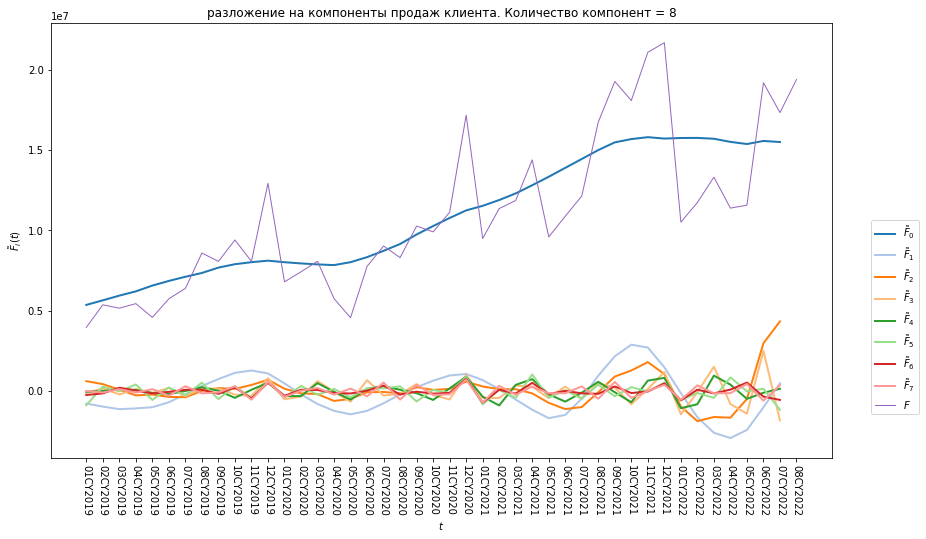

In [383]:
# F = Clients_turnover_list[0]
F = list(df_turnover_months['Turnover'])
N = 43
L = 8 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.

X = np.column_stack([F[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive.

d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")
    
#построим первые n элементарных компонентов,  𝐹̃ 𝑖 , для временного ряда.
n = min(12,d) # In case of noiseless time series with d < n.

# Fiddle with colour cycle - need more colours!
plt.figure(figsize=(14,8))
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(F_i, lw=2)

fig.axes.plot(df_turnover_months['Month'], F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("разложение на компоненты продаж клиента. Количество компонент = " + str(L))
plt.xticks (Rotation = -90)
fig.legend(legend, loc=(1.05,0.1));

можно предположить, что 0 и 1 компонента - это тренд, 2,3 - периодичность номер 1  
4 и 5 компонента - периодичность номер 2  
6 и далее - это шум

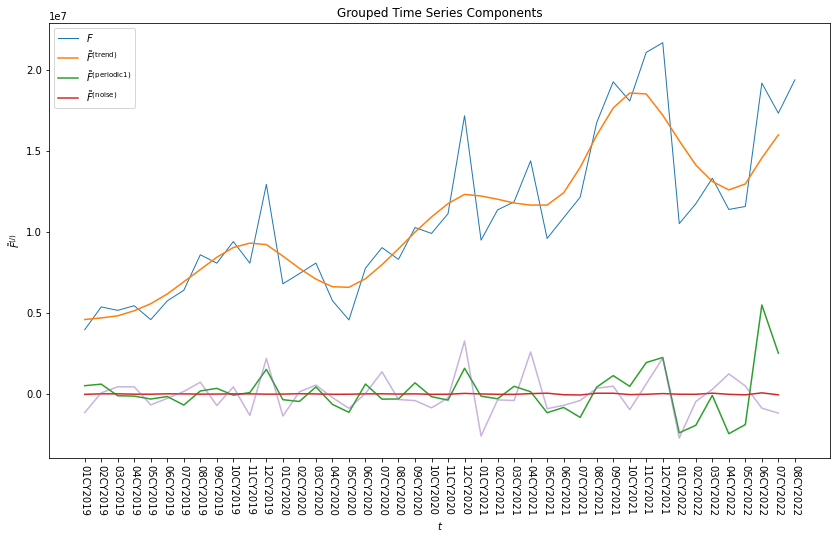

<Figure size 432x288 with 0 Axes>

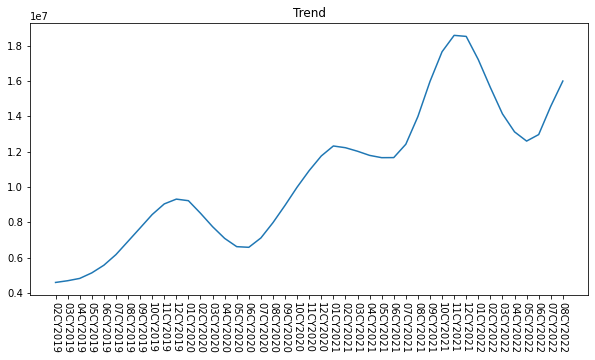

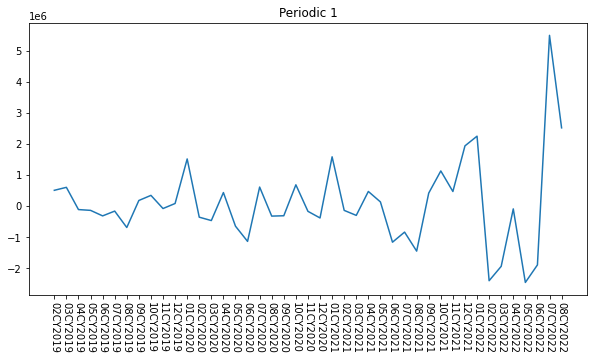

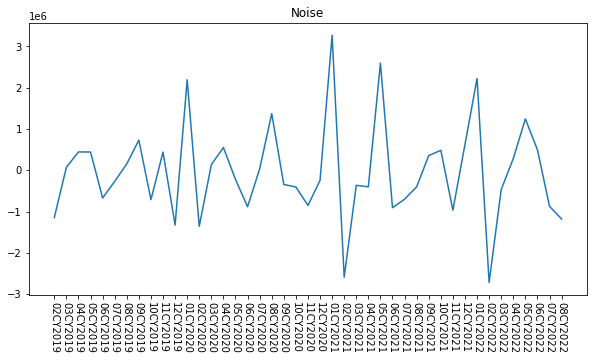

In [384]:
# Assemble the grouped components of sales.
F_trend = X_to_TS(X_elem[[0,1]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[2,3]].sum(axis=0))
# F_periodic2 = X_to_TS(X_elem[[4,5]].sum(axis=0))
F_noise = X_to_TS(X_elem[4:].sum(axis=0))

# Plot the sales of client and its separated components on a single plot.
plt.figure(figsize=(14,8))
plt.plot(df_turnover_months['Month'],F, lw=1)
plt.plot(F_trend)
plt.plot(F_periodic1)
plt.plot(F_periodic2)
plt.plot(F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.xticks (Rotation = -90)
plt.show()

# A list of tuples so we can create the next plot with a loop.
components = [('Trend', F_trend), 
              ('Periodic 1', F_periodic1),
#               ('Periodic 2', F_periodic2),
              ('Noise', F_noise)]

# Plot the separated components and original components together.
fig = plt.figure()
n=1
for name, ssa_comp in components:    
#     ax = fig.add_subplot(2,2,n)
#     ax.plot(df_turnover_months['Month'][1:], ssa_comp)
    plt.figure(figsize=(10,5))
    plt.plot(df_turnover_months['Month'][1:], ssa_comp)
    plt.xticks (Rotation = -90)
    plt.title(name)
#     ax.set_title(name, fontsize=16)
#     ax.set_xticks([])
    n += 1
    plt.show()

fig.tight_layout()

In [81]:
#построим w-корреляционную матрицу для временного ряда продаж клиента
# Get the weights w first, as they'll be reused a lot.
# Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w), 
# [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
# list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
# Add all the lists together and we have our array of weights.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

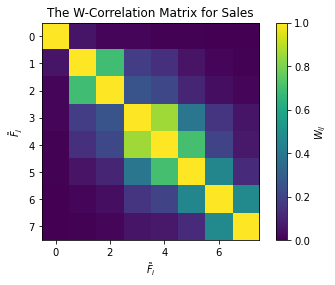

In [82]:
#График w-корреляционной матрицы.
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for Sales");

в принципе по матрице можно сказать, что допустимо объеденить 1 и 2 компонент, 3-6 компонент и 7-8 компонент

In [83]:
# соберем код SSA в удобный класс, образно названный SSA
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

# L = 2

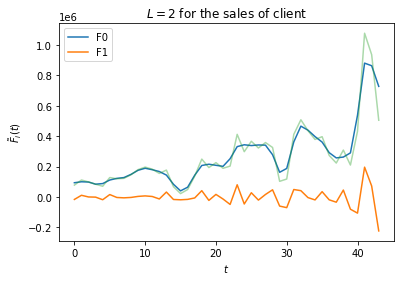

In [84]:
F_ssa_L2 = SSA(F, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the sales of client");

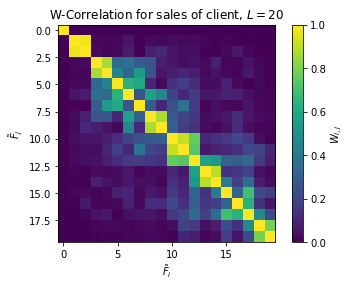

In [385]:
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for sales of client, $L=20$");

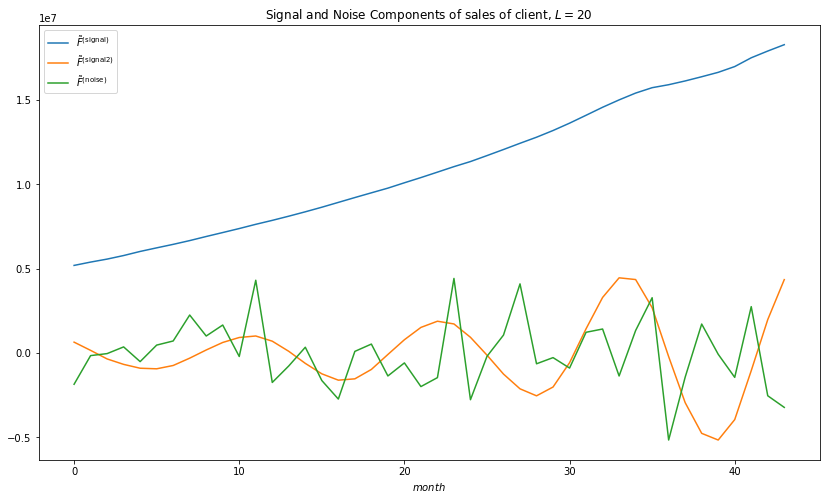

In [396]:
# F_ssa_L20.reconstruct(0).plot()
# F_ssa_L20.reconstruct(slice(0,7)).plot()
# F_ssa_L20.reconstruct(slice(7,20)).plot()
plt.figure(figsize=(14,8))
plt.plot(F_ssa_L20.reconstruct(0))
plt.plot(F_ssa_L20.reconstruct(slice(1,3)))
# plt.plot(F_ssa_L20.reconstruct(slice(2,3)))
plt.plot(F_ssa_L20.reconstruct(slice(3,20)))
# plt.plot(F_ssa_L20.reconstruct(slice(11,20)))

plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(signal2)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of sales of client, $L = 20$")
plt.xlabel(r"$month$");
plt.show()

# Нейронные сети  (прогноз оборота клиента в отдельности и компании в целом)

In [87]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [162]:
df = df_original.copy()
df_columns = df.columns

In [89]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error

In [163]:
# dataset = pd.DataFrame()
# dataset['Month'] = np.arange(len(F)) + 1
# dataset['Turnover'] = pd.DataFrame(F) #F = Clients_turnover_list[0]
dataset = pd.DataFrame(F)

In [142]:
print('min = ' + str(dataset[0].min()))
print('max = ' + str(dataset[0].max()))
print('mean = ' + str(dataset[0].mean()))

min = 22673.0
max = 1076463.6
mean = 263537.8636363636


In [213]:
# dataset[0]

Оборот разбиваем по критерям. Нам важно предсказать диапазон оборота

In [502]:
# dataset = pd.DataFrame(F)
dataset = pd.DataFrame(list(df_turnover_months['Turnover']))
Y = dataset[0]
# X = df_original.copy()
# del X['08CY2022']
# del X['Клиент']
# Y = df_original['08CY2022'].copy()

# criteria = [Y <= 200, Y.between(200, 100000), Y.between(100000, 200000), Y.between(200000, 300000), 
#                 Y.between(300000, 400000), Y.between(400000, 500000), Y.between(500000, 600000),
#                 Y.between(600000, 700000), Y.between(700000, 800000), Y.between(800000, 900000),
#                 Y >= 900000]
# values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Y = np.select(criteria, values, 0)

# dataset[0] = Y

In [503]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

делим на тестовую и train выборки

In [466]:
#каждый третий месяц на тест
# test_ind_list = []
# train_ind_list = []
# for i in range(len(dataset)):
#     if i % 5 == 0 :
#         test_ind_list.append(i)
#     else:
#         train_ind_list.append(i)
        
# print(len(train_ind_list), len(test_ind_list))

# train, test = dataset[train_ind_list,:], dataset[test_ind_list,:]
# print(len(train_ind_list), len(test_ind_list))
train, test = dataset[:-6,:], dataset[-6:,:]

In [467]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [505]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(12, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
36/36 - 4s - loss: 0.1415 - 4s/epoch - 106ms/step
Epoch 2/100
36/36 - 0s - loss: 0.1008 - 74ms/epoch - 2ms/step
Epoch 3/100
36/36 - 0s - loss: 0.0742 - 64ms/epoch - 2ms/step
Epoch 4/100
36/36 - 0s - loss: 0.0584 - 61ms/epoch - 2ms/step
Epoch 5/100
36/36 - 0s - loss: 0.0494 - 59ms/epoch - 2ms/step
Epoch 6/100
36/36 - 0s - loss: 0.0444 - 59ms/epoch - 2ms/step
Epoch 7/100
36/36 - 0s - loss: 0.0426 - 61ms/epoch - 2ms/step
Epoch 8/100
36/36 - 0s - loss: 0.0409 - 59ms/epoch - 2ms/step
Epoch 9/100
36/36 - 0s - loss: 0.0398 - 58ms/epoch - 2ms/step
Epoch 10/100
36/36 - 0s - loss: 0.0398 - 101ms/epoch - 3ms/step
Epoch 11/100
36/36 - 0s - loss: 0.0397 - 59ms/epoch - 2ms/step
Epoch 12/100
36/36 - 0s - loss: 0.0385 - 70ms/epoch - 2ms/step
Epoch 13/100
36/36 - 0s - loss: 0.0373 - 69ms/epoch - 2ms/step
Epoch 14/100
36/36 - 0s - loss: 0.0366 - 65ms/epoch - 2ms/step
Epoch 15/100
36/36 - 0s - loss: 0.0363 - 65ms/epoch - 2ms/step
Epoch 16/100
36/36 - 0s - loss: 0.0356 - 62ms/epoch - 2ms/step


In [478]:
model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 12)                672       
                                                                 
 dense_76 (Dense)            (None, 1)                 13        
                                                                 
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


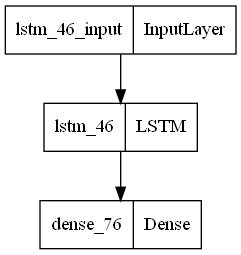

In [479]:
keras.utils.plot_model(model, "diplom_model_RNN_LSTM.png")

In [506]:
forecasted = testPredict[:,0]
actual = testY[0]

mape = 0
for i in range(len(actual)):
    mape = mape + np.abs( ( actual[i] - forecasted[i] ) / actual[i])
#     print(np.abs( ( actual[i] - forecasted[i] ) / actual[i]))
print('MAPE = ', round(mape / len(actual) * 100, 1), '%')

MAPE =  14.1 %


In [491]:
testX

array([[[0.52781603]],

       [[0.41900573]],

       [[0.42940591]],

       [[0.85921205]]])

In [496]:
model.predict(testX)

array([[0.49456003],
       [0.41330287],
       [0.42104647],
       [0.7382583 ]], dtype=float32)

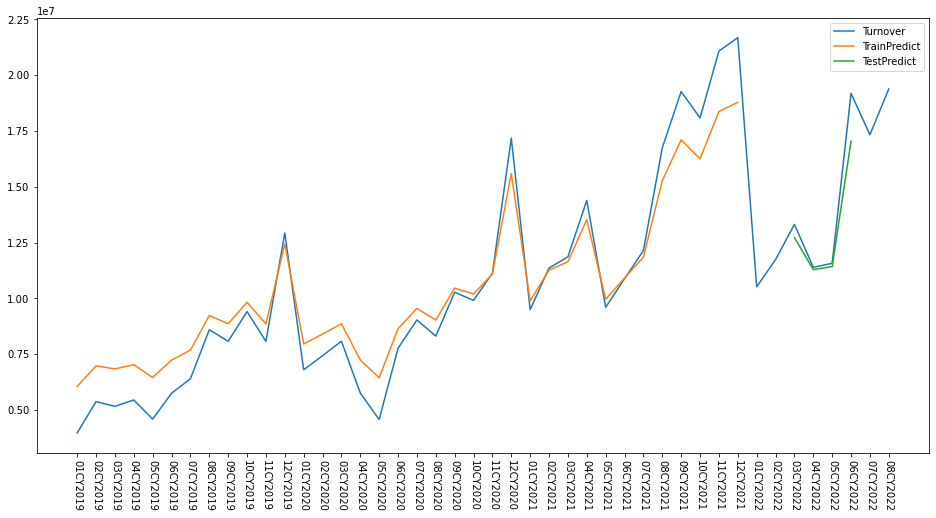

In [489]:
plt.figure(figsize=(16, 8))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(df_turnover_months['Month'], scaler.inverse_transform(dataset), label = 'Turnover') #df_turnover_months['Month'] ,
plt.plot(trainPredictPlot[1:], label = 'TrainPredict')
plt.plot(testPredictPlot[1:], label = 'TestPredict')
plt.xticks (Rotation = -90)
plt.legend()
plt.show()

In [301]:
# lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
# lr.fit(X_train, y_train)
# prediction = lr.predict(X_test)
# plt.figure(figsize=(15, 7))
# plt.plot(prediction, "r", label="prediction")
# plt.plot(y_test, label="actual")
# plt.legend(loc="best")
# # plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, testY))))
# plt.grid(True);

# Введем в модель предсказания месячного суммарного оборота компании  
курс USD средний за месяц  
курс USD макс за месяц  
курс USD мин за месяц  
ставка рефинанс (какая была в месяце)  
температура средняя в месяце  
индекс РТС  
цена нефть USD средняя за месяц   
цена нефть USD мин за месяц   
цена нефть USD макс за месяц  


In [74]:
# from datetime import datetime

In [104]:
df_brent = pd.read_csv('Brent1.csv', sep = ';', decimal=',')

In [105]:
df_brent.head()

,Month,Brent_price,Brent_Max,Brent_Min,Brent_Volume
0,08CY2022,95.64,104.41,91.52,0.29
1,07CY2022,110.01,114.75,94.50,4.28
2,06CY2022,114.81,125.19,107.03,4.46
3,05CY2022,122.84,125.28,101.30,4.50
4,04CY2022,109.34,114.84,97.57,3.80


In [106]:
df_RTS = pd.read_csv('RTS.csv', sep = ';', decimal=',')

In [107]:
df_RTS.head()

,Month,RTS_price,RTS_open,RTS_max,RTS_min
0,08CY2022,1258.45,1131.74,1273.96,1069.35
1,07CY2022,1129.24,1345.75,1345.75,1082.62
2,06CY2022,1345.01,1203.66,1495.66,1155.91
3,05CY2022,1208.12,1085.11,1324.10,1070.14
4,04CY2022,1081.52,1027.84,1132.71,885.44


In [108]:
df_Temperature = pd.read_csv('Temperature.csv',sep = ';', decimal=',')

In [109]:
df_Temperature.head()

,Month,Temperature
0,01CY2019,-6.6
1,02CY2019,-1.4
2,03CY2019,0.7
3,04CY2019,8.1
4,05CY2019,16.3


In [110]:
df_Stavka_refinans = pd.read_csv('Stavka_refinans.csv',sep = ';', decimal=',')

In [111]:
df_Stavka_refinans.head()

,Month,Stavka_Refinans
0,01CY2019,7.75
1,02CY2019,7.75
2,03CY2019,7.75
3,04CY2019,7.75
4,05CY2019,7.75


In [128]:
# result_1 = pd.concat([df_brent, df_RTS, df_Temperature, df_Stavka_refinans ])
df_join = df_brent.join(df_RTS.set_index('Month'), on='Month')
df_join = df_join.join(df_Temperature.set_index('Month'), on='Month')
df_join = df_join.join(df_Stavka_refinans.set_index('Month'), on='Month')
df_join = df_join.join(df_turnover_months[['Month', 'Turnover']].set_index('Month'), on='Month')
df_join.head()

,Month,Brent_price,Brent_Max,Brent_Min,Brent_Volume,RTS_price,RTS_open,RTS_max,RTS_min,Temperature,Stavka_Refinans,Turnover
0,08CY2022,95.64,104.41,91.52,0.29,1258.45,1131.74,1273.96,1069.35,25.0,8.0,19388322.2
1,07CY2022,110.01,114.75,94.50,4.28,1129.24,1345.75,1345.75,1082.62,23.0,9.5,17330522.2
2,06CY2022,114.81,125.19,107.03,4.46,1345.01,1203.66,1495.66,1155.91,18.9,9.5,19186653.2
3,05CY2022,122.84,125.28,101.30,4.50,1208.12,1085.11,1324.10,1070.14,10.7,14.0,11572625.0
4,04CY2022,109.34,114.84,97.57,3.80,1081.52,1027.84,1132.71,885.44,5.8,17.0,11388385.6


In [129]:
df_join['Sum_3previous_months'] = df_join['Turnover'].shift(-1) + df_join['Turnover'].shift(-2) + df_join['Turnover'].shift(-3)
df_join['Sum_3previous_months'][len(df_join)-1] = df_join['Turnover'][len(df_join)-1]
df_join['Sum_3previous_months'][len(df_join)-2] = df_join['Turnover'][len(df_join)-2] + df_join['Turnover'][len(df_join)-1]
df_join['Sum_3previous_months'][len(df_join)-3] = df_join['Turnover'][len(df_join)-3] + df_join['Turnover'][len(df_join)-2] + df_join['Turnover'][len(df_join)-3]

In [130]:
df_join['Year'] = df_join['Month'].str[4:]
df_join['Month'] = df_join['Month'].str[:2]

In [131]:
# from sklearn import preprocessing
# df_join_normalize = preprocessing.normalize(df_join, axis=0)
df_join_normalize = df_join.copy()

In [132]:
# df_join_normalize = pd.DataFrame(df_join_normalize, columns=df_join.columns)
df_join_normalize.head()

,Month,Brent_price,Brent_Max,Brent_Min,Brent_Volume,RTS_price,RTS_open,RTS_max,RTS_min,Temperature,Stavka_Refinans,Turnover,Sum_3previous_months,Year
0,08,95.64,104.41,91.52,0.29,1258.45,1131.74,1273.96,1069.35,25.0,8.0,19388322.2,48089800.4,2022
1,07,110.01,114.75,94.50,4.28,1129.24,1345.75,1345.75,1082.62,23.0,9.5,17330522.2,42147663.8,2022
2,06,114.81,125.19,107.03,4.46,1345.01,1203.66,1495.66,1155.91,18.9,9.5,19186653.2,36276973.8,2022
3,05,122.84,125.28,101.30,4.50,1208.12,1085.11,1324.10,1070.14,10.7,14.0,11572625.0,36439999.8,2022
4,04,109.34,114.84,97.57,3.80,1081.52,1027.84,1132.71,885.44,5.8,17.0,11388385.6,35567834.4,2022


In [133]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_join_normalize['Month'])
# Drop column B as it is now encoded
df_join_normalize = df_join_normalize.drop('Month',axis = 1)
# Join the encoded df
df_join_normalize = df_join_normalize.join(one_hot) 

In [134]:
df_join_normalize.head()

,Brent_price,Brent_Max,Brent_Min,Brent_Volume,RTS_price,RTS_open,RTS_max,RTS_min,Temperature,Stavka_Refinans,...,03,04,05,06,07,08,09,10,11,12
0,95.64,104.41,91.52,0.29,1258.45,1131.74,1273.96,1069.35,25.0,8.0,...,0,0,0,0,0,1,0,0,0,0
1,110.01,114.75,94.50,4.28,1129.24,1345.75,1345.75,1082.62,23.0,9.5,...,0,0,0,0,1,0,0,0,0,0
2,114.81,125.19,107.03,4.46,1345.01,1203.66,1495.66,1155.91,18.9,9.5,...,0,0,0,1,0,0,0,0,0,0
3,122.84,125.28,101.30,4.50,1208.12,1085.11,1324.10,1070.14,10.7,14.0,...,0,0,1,0,0,0,0,0,0,0
4,109.34,114.84,97.57,3.80,1081.52,1027.84,1132.71,885.44,5.8,17.0,...,0,1,0,0,0,0,0,0,0,0


In [135]:
df_join_normalize['Sum_3previous_months'].max()

60846994.99999999

In [136]:
X = df_join_normalize.copy()
del X['Turnover']
# del X['Year']
# del X['RTS_open']
# del X['Temperature']
Y = df_join_normalize['Turnover'].copy()

# criteria = [Y <= 0.1, 
#                 Y.between(0.1, 0.15), Y.between(0.15, 0.2), Y.between(0.2, 0.25), Y >= 0.25]
# criteria = [Y <= 5000000, 
#                 Y.between(5000000, 8000000), Y.between(8000000, 12000000), Y.between(12000000, 18000000), Y >= 18000000]
# values = [1, 2, 3, 4, 5]

# Y = np.select(criteria, values, 0)
criteria = [Y <= 5000000, Y.between(5000000, 7000000), Y.between(7000000, 9000000), Y.between(9000000, 11000000), 
                Y.between(11000000, 13000000), Y.between(13000000, 15000000), Y.between(15000000, 17000000),
                Y.between(17000000, 19000000), Y.between(19000000, 21000000), Y >= 21000000]
values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Y = np.select(criteria, values, 0)



In [142]:
criteria_X = [X['Sum_3previous_months'] <= 15000000, 
              X['Sum_3previous_months'].between(15000000, 24000000), 
              X['Sum_3previous_months'].between(24000000, 36000000), 
              X['Sum_3previous_months'].between(36000000, 54000000), 
              X['Sum_3previous_months']>= 54000000]

# criteria_X = [X['Sum_3previous_months'] <= 0.1, 
#               X['Sum_3previous_months'].between(0.1, 0.15), 
#               X['Sum_3previous_months'].between(0.15, 0.2), 
#               X['Sum_3previous_months'].between(0.2, 0.25), 
#               X['Sum_3previous_months']>= 0.25]

values_X = [1, 2, 3, 4, 5]

X['Sum_3previous_months'] = np.select(criteria_X, values_X, 0)

In [143]:
X.head()

,Brent_price,Brent_Max,Brent_Min,Brent_Volume,RTS_price,RTS_open,RTS_max,RTS_min,Temperature,Stavka_Refinans,...,03,04,05,06,07,08,09,10,11,12
0,95.64,104.41,91.52,0.29,1258.45,1131.74,1273.96,1069.35,25.0,8.0,...,0,0,0,0,0,1,0,0,0,0
1,110.01,114.75,94.50,4.28,1129.24,1345.75,1345.75,1082.62,23.0,9.5,...,0,0,0,0,1,0,0,0,0,0
2,114.81,125.19,107.03,4.46,1345.01,1203.66,1495.66,1155.91,18.9,9.5,...,0,0,0,1,0,0,0,0,0,0
3,122.84,125.28,101.30,4.50,1208.12,1085.11,1324.10,1070.14,10.7,14.0,...,0,0,1,0,0,0,0,0,0,0
4,109.34,114.84,97.57,3.80,1081.52,1027.84,1132.71,885.44,5.8,17.0,...,0,1,0,0,0,0,0,0,0,0


In [144]:
# model = LogisticRegression() # берем в качестве модели логистическую регресиию из scikit-learn
model = LogisticRegression(solver='liblinear')

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [146]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [147]:
model.score(X_train, y_train) 

0.8571428571428571

In [148]:
model.score(X_test,y_test)

0.4444444444444444

In [149]:
# используем пайплайны
clf = make_pipeline(StandardScaler(), SVC(gamma='auto')) 
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [150]:
clf.score(X_train, y_train) 

0.7428571428571429

In [151]:
clf.score(X_test, y_test)

0.3333333333333333

In [152]:
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [153]:
svc.score(X_train, y_train)

1.0

In [154]:
svc.score(X_test, y_test)

0.1111111111111111

In [155]:
lda = LinearDiscriminantAnalysis()

In [156]:
# обучаем данные
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [157]:
lda.score(X_train, y_train)

1.0

In [158]:
lda.score(X_test, y_test)

0.4444444444444444

In [159]:
len(set(Y))
# X.shape[1]

10

попробуем использовать нейроную сеть

In [162]:
#формируем слои сети
# на входе количество месяцев qty_months_int
# на выходе критерий qty_output_int
qty_months_int = X.shape[1]
# qty_output_int = max(X.nunique())
qty_output_int = len(set(Y))+1

inputs = keras.Input(shape=(qty_months_int,)) # qty months - количество месяцев (month)
x = layers.Dense(2)(inputs) ### объявление слоя (32)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Activation('relu')(x)
x = layers.BatchNormalization()(x) #добавил 1109
x = layers.Dropout(0.5)(x)
#x = dense1(inputs) ### указание входного тензора

# y = layers.Dense(16)(inputs) #32
# y = layers.BatchNormalization()(y)
# y = layers.Dropout(0.5)(y)
# y = layers.Activation('relu')(y)

# dense21 = layers.Dense(16, activation="relu")(x) #32
# dense22 = layers.Dense(16, activation='relu')(y) #32

# dense3 = layers.Add()([dense21, dense22])

x = layers.Dense(2, activation="relu")(x) #32
outputs = layers.Dense(qty_output_int+1)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="diplom_model_Keras")

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), ### ОТЛИЧИЕ_ОТ_CategoricalCrossEntropy
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(np.array(X_train, dtype=np.float), np.array(y_train, dtype=np.float), batch_size=16, 
                    epochs=20, validation_split=0.3)

test_scores = model.evaluate(np.array(X_test, dtype=np.float), np.array(y_test, dtype=np.float), verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/20
2/2 [==============================] - 3s 383ms/step - loss: 2.5537 - accuracy: 0.0417 - val_loss: 5.1680 - val_accuracy: 0.0909
Epoch 2/20
2/2 [==============================] - 0s 65ms/step - loss: 2.5836 - accuracy: 0.0833 - val_loss: 4.1900 - val_accuracy: 0.0909
Epoch 3/20
2/2 [==============================] - 0s 71ms/step - loss: 2.5496 - accuracy: 0.0000e+00 - val_loss: 3.7665 - val_accuracy: 0.0909
Epoch 4/20
2/2 [==============================] - 0s 66ms/step - loss: 2.5034 - accuracy: 0.0417 - val_loss: 3.4997 - val_accuracy: 0.0909
Epoch 5/20
2/2 [==============================] - 0s 67ms/step - loss: 2.4839 - accuracy: 0.0833 - val_loss: 3.3644 - val_accuracy: 0.0909
Epoch 6/20
2/2 [==============================] - 0s 64ms/step - loss: 2.5762 - accuracy: 0.1250 - val_loss: 3.1314 - val_accuracy: 0.0909
Epoch 7/20
2/2 [==============================] - 0s 71ms/step - loss: 2.4725 - accuracy: 0.1667 - val_loss: 3.0274 - val_accuracy: 0.0909
Epoch 8/20
2/2 [======

видно, что моделям не хватает важных парамеров, которые нужно добавлять

# Итого
проанализировали  
оборот компании по месяцев  
клиентскую базу + сделали рекомендации по количесву сейлс менеджеров  
выделили крупные компании и построили модели ARIMA по каждой  
разложили оборот крупных компаний на компоненты и выделили шумы  
построили нейроную сеть  
попытались с помощью нейронной сети и сторонних параметров предсказать оборот
